In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from toolbox_02450 import rlr_validate, train_neural_net, draw_neural_net, visualize_decision_boundary
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

# Importing data

In [2]:
df = pd.read_csv('data.csv')
df = df.drop('row.names',axis=1)
df['famhist'] = df['famhist'].replace({'Present': 1, 'Absent': 0})
df.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,160,12.00,5.73,23.11,1,49,25.30,97.20,52,1
1,144,0.01,4.41,28.61,0,55,28.87,2.06,63,1
2,118,0.08,3.48,32.28,1,52,29.14,3.81,46,0
3,170,7.50,6.41,38.03,1,51,31.99,24.26,58,1
4,134,13.60,3.50,27.78,1,60,25.99,57.34,49,1


# Regression A

### 1)
Explain what variable is predicted based on which other variables and what
you hope to accomplish by the regression. Mention your feature transformation
choices such as one-of-K coding. Since we will use regularization momentarily,
apply a feature transformation to your data matrix X such that each column
has mean 0 and standard deviation 1.

In [4]:
target_variable = 'sbp'
features = df.drop(columns=[target_variable]).columns

# Prepare the feature matrix X and the target vector y
X = df[features]
y = df[target_variable].squeeze().values

# We have used one-of-K coding for feature transformation by substituting famhist = present or absent by 1 or 0, respectively

# Feature scaling so that each feature column has mean = 0 and standard deviation = 1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=features)
X_scaled_df.head()

,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1.823073,0.478412,-0.295503,1.185854,-0.418470,-0.176786,3.277738,0.629336,1.373863
1,-0.790237,-0.159680,0.412140,-0.843274,0.193344,0.671373,-0.612745,1.383115,1.373863
2,-0.774980,-0.609245,0.884332,1.185854,-0.112563,0.735519,-0.541183,0.218184,-0.727875
3,0.842264,0.807126,1.624141,1.185854,-0.214532,1.412621,0.295062,1.040488,1.373863
4,2.171805,-0.599577,0.305351,1.185854,0.703189,-0.012856,1.647775,0.423760,1.373863


### 2)

Introduce a regularization parameter λ as discussed in chapter 14 of the lecture
notes, and estimate the generalization error for different values of λ. Specifically, choose a reasonable range of values of λ (ideally one where the generalization error first drop and then increases), and for each value use K = 10 fold
cross-validation (algorithm 5) to estimate the generalization error.
Include a figure of the estimated generalization error as a function of λ in the
report and briefly discuss the result.

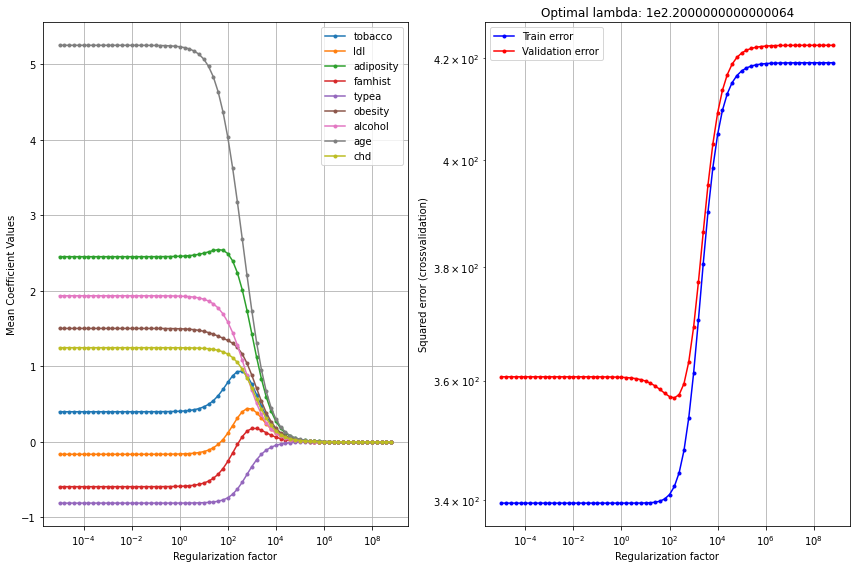

Regularized linear regression:
- Training error: 342.80651309263266
Optimal lambda: 1e2.2000000000000064
Weights:
         Offset        138.3268
        tobacco          0.8522
            ldl          0.1858
      adiposity          2.4297
        famhist         -0.1753
          typea         -0.7064
        obesity          1.3101
        alcohol          1.4786
            age          3.7321
            chd          1.1329


In [5]:
X = X_scaled_df

# Attributes names:
attributeNames = X.columns.values.tolist()

# Compute values of N, M
N, M = X.shape

# Add offset attribute
X = np.concatenate((np.ones((X.shape[0], 1)), X), 1)
attributeNames = [u'Offset'] + attributeNames
M = M + 1

K = 10

# --------------------Regression Part A ------------------#
# Values of lambda
lambdas = np.power(10.,np.arange(-5,9,0.2))

# Initialize variables
Error_train_rlr = np.empty((1,1))
w_rlr = np.empty((M,1))
mu = np.empty((1, M-1))
sigma = np.empty((1, M-1))

opt_val_err, opt_lambda, mean_w_vs_lambda, train_err_vs_lambda, test_err_vs_lambda = rlr_validate(X, y, lambdas, K)

Xty = X.T @ y
XtX = X.T @ X

# Estimate weights for the optimal value of lambda, on entire training set
lambdaI = opt_lambda * np.eye(M)
lambdaI[0,0] = 0 # Do no regularize the bias term
w_rlr[:,0] = np.linalg.solve(XtX+lambdaI,Xty).squeeze()
# Compute mean squared error with regularization with optimal lambda
Error_train_rlr[0] = np.square(y-X @ w_rlr[:,0]).sum(axis=0)/y.shape[0]

# Display the results
plt.figure(1, figsize=(12,8))
plt.subplot(1,2,1)
plt.semilogx(lambdas,mean_w_vs_lambda.T[:,1:],'.-') # Don't plot the bias term
plt.xlabel('Regularization factor')
plt.ylabel('Mean Coefficient Values')
plt.legend(attributeNames[1:], loc='best')
plt.grid()

plt.subplot(1,2,2)
plt.title('Optimal lambda: 1e{0}'.format(np.log10(opt_lambda)))
plt.loglog(lambdas,train_err_vs_lambda.T,'b.-',lambdas,test_err_vs_lambda.T,'r.-')
plt.xlabel('Regularization factor')
plt.ylabel('Squared error (crossvalidation)')
plt.legend(['Train error','Validation error'])
plt.grid()

plt.tight_layout()
plt.show()

# Display results
print('Regularized linear regression:')
print('- Training error: {0}'.format(Error_train_rlr.mean()))

# Optimal lambda
print('Optimal lambda: 1e{0}'.format(np.log10(opt_lambda)))

print('Weights:')
for m in range(M):
    print('{:>15} {:>15}'.format(attributeNames[m], np.round(w_rlr[m,0],4)))
    

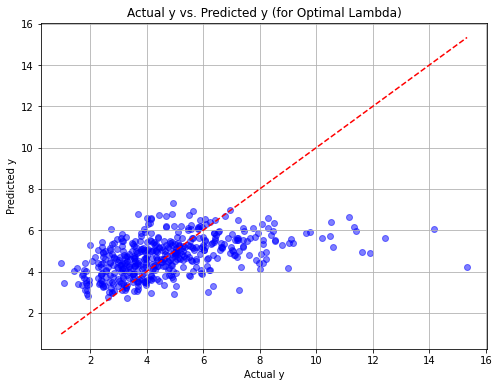

In [ ]:
# Predict y_est
y_est = X @ w_rlr

# Plot y vs. y_est
plt.figure(figsize=(8, 6))
plt.scatter(y, y_est, c='blue', marker='o', alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], c='red', linestyle='--')
plt.title('Actual y vs. Predicted y (for Optimal Lambda)')
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.grid(True)
plt.show()


### 3)

Explain how the output, y, of the linear model with the lowest generalization
error (as determined in the previous question) is computed for a given input
x. What is the effect of an individual attribute in x on the output, y, of the
linear model? Does the effect of individual attributes make sense based on your
understanding of the problem?

# Regression B

In [46]:
# Getting the dataset
target_variable = 'sbp'
features = df.drop(columns=[target_variable]).columns

# Prepare the feature matrix X and the target vector y
X = df[features]
y = df[target_variable].squeeze().values

# We have used one-of-K coding for feature transformation by substituting famhist = present or absent by 1 or 0, respectively

# Feature scaling so that each feature column has mean = 0 and standard deviation = 1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=features)

X = X_scaled_df

# Attributes names:
attributeNames = X.columns.values.tolist()

# Compute values of N, M
N, M = X.shape


#--------------------Regression Part B ------------------#
# Add offset attribute
X = np.concatenate((np.ones((X.shape[0], 1)), X), 1)
attributeNames = [u'Offset'] + attributeNames
M = M + 1

K1 = 10
K2 = 10

CV1 = model_selection.KFold(K1, shuffle=True)
CV2 = model_selection.KFold(K2, shuffle=True)

# Values of lambda
lambdas = np.power(10.,np.arange(-5,9,0.2))

# Initialize variables RLR
Error_train_rlr = np.empty((K1,1))
Error_test_rlr = np.empty((K1,1))
w_rlr = np.empty((M,K1))

# Initialize variables for ANN
Errors_train_ANN = []
Errors_test_ANN = []
ANN_overall_error = np.empty(K1)
max_iter = 100000
n_replicates = 1
best_h_ANN = [0] * K1
n_hidden_units = [1,2,4,8,10,15,20]

# Init loss function
loss_fn = torch.nn.MSELoss()

# Setup figure for display of learning curves and error rates in fold
learn_curve_plot = plt.figure(figsize=(6,6))
# Make a list for storing assigned color of learning curve for up to K=10
color_list = ['tab:orange', 'tab:green', 'tab:purple', 'tab:brown', 'tab:pink',
              'tab:gray', 'tab:olive', 'tab:cyan', 'tab:red', 'tab:blue']# Make a list for storing assigned color of learning curve for up to K=10

k1 = 0
for train_index_outer, test_index_outer in CV1.split(X_scaled_df,y):
    X_train = X[train_index_outer]
    y_train = y[train_index_outer]
    X_test = X[test_index_outer]
    y_test = y[test_index_outer]

    M = X.shape[1]
    w = np.empty((M,K2,len(lambdas)))
    train_error = np.empty((K2,len(lambdas)))
    test_error = np.empty((K2,len(lambdas)))
    
    XtX = X_train.T @ X_train
    Xty = X_train.T @ y_train
    
    ANN_models_error = np.empty(len(n_hidden_units))

    k2 = 0
    for train_index_inner, test_index_inner in CV2.split(X_train,y_train):
        print('\nCrossvalidation fold: {0}/{1} outer {2}/{3} inner'.format(k1+1,K1,k2+1,K2)) 
        
        ### Find best lambda value ###
        X_train_inner = X_train[train_index_inner]
        y_train_inner = y_train[train_index_inner]
        X_test_inner = X_train[test_index_inner]
        y_test_inner = y_train[test_index_inner]
        
        XtX_inner = X_train_inner.T @ X_train_inner
        Xty_inner = X_train_inner.T @ y_train_inner   
        
        for l in range(0,len(lambdas)):
            # Compute parameters for current value of lambda and current CV fold
            # note: "linalg.lstsq(a,b)" is substitue for Matlab's left division operator "\"
            lambdaI_inner = lambdas[l] * np.eye(M)
            lambdaI_inner[0,0] = 0 # remove bias regularization
            w[:,k2,l] = np.linalg.solve(XtX_inner+lambdaI_inner,Xty_inner).squeeze()
            # Evaluate training and test performance
            train_error[k2,l] = np.power(y_train_inner - X_train_inner @ w[:,k2,l].T,2).mean(axis=0)
            test_error[k2,l] = np.power(y_test_inner - X_test_inner @ w[:,k2,l].T,2).mean(axis=0)
            
            
        k2 += 1
        
        opt_val_err = np.min(np.mean(test_error,axis=0))
        opt_lambda = lambdas[np.argmin(np.mean(test_error,axis=0))]
        train_err_vs_lambda = np.mean(train_error,axis=0)
        test_err_vs_lambda = np.mean(test_error,axis=0)
        mean_w_vs_lambda = np.squeeze(np.mean(w,axis=1))
    
        ### Find best h value ###
        # Creating tensonrs for each fold
        X_train_inner_tensor = torch.Tensor(X_train[train_index_inner,:] )
        y_train_inner_tensor = torch.Tensor(y_train[train_index_inner] )
        X_test_inner_tensor = torch.Tensor(X_train[test_index_inner,:] )
        y_test_inner_tensor = torch.Tensor(y_train[test_index_inner] )


        for i, h_value in enumerate(n_hidden_units):
            
            model = lambda: torch.nn.Sequential(
                                torch.nn.Linear(M, h_value), #M features to n_hidden_units
                                torch.nn.Tanh(),   # 1st transfer function,
                                torch.nn.Linear(h_value, 1), # n_hidden_units to 1 output neuron
                                # no final tranfer function, i.e. "linear output"
                                )
            #Train model  
            net, final_loss, learning_curve = train_neural_net(model,
                                                   loss_fn,
                                                   X=X_train_inner_tensor,
                                                   y=y_train_inner_tensor,
                                                   n_replicates=n_replicates,
                                                   max_iter=max_iter)
            
            # Determine estimated values for test set
            y_test_est = net(X_test_inner_tensor)
            
            # Determine squared errors and mean squared errors
            se = (y_test_est.float().detach().numpy().flatten()-y_test_inner_tensor.float().detach().numpy().flatten())**2 # squared error
            mse_ANN = sum(se) / len(y_test_inner_tensor) #mean
            
            ANN_models_error[i] += mse_ANN # store error rate for current CV fold
    
    #Make tensors
    X_train_tensor = torch.Tensor(X_train)
    y_train_tensor = torch.Tensor(y_train)
    X_test_tensor = torch.Tensor(X_test)
    y_test_tensor = torch.Tensor(y_test)

    '''------------------ANN-------------------'''

    #choose best model
    best_h_ANN[k1] = n_hidden_units[np.argmin(ANN_models_error)]
    model = lambda: torch.nn.Sequential(
                        torch.nn.Linear(M, best_h_ANN[k1]), #M features to n_hidden_units
                        torch.nn.Tanh(),   # 1st transfer function,
                        torch.nn.Linear(best_h_ANN[k1], 1), # n_hidden_units to 1 output neuron
                        # no final tranfer function, i.e. "linear output"
                        )
    # Train best model on training data
    net, final_loss, learning_curve = train_neural_net(model,
                                                    loss_fn,
                                                    X=X_train_tensor,
                                                    y=y_train_tensor,
                                                    n_replicates=n_replicates,
                                                    max_iter=max_iter)
    # Determine estimated class labels for test set
    ANN_y_test_est = net(X_test_tensor)
        
        # Determine errors and errors
    se = (ANN_y_test_est.float().flatten()-y_test_tensor.float().flatten())**2 # squared error
    mse = (sum(se).type(torch.float)/len(y_test_tensor)).data.numpy() #mean
    ANN_overall_error[k1] = mse

    # Display the learning curve for the best net in the current fold
    h_curve, = plt.plot(learning_curve, color=color_list[k1])
    h_curve.set_label('CV fold {0}'.format(k1+1))
    plt.xlabel('Iterations')
    plt.xlim(0, max_iter)
    plt.ylabel('Loss')
    plt.title('ANN Learning curves')
    
    ### Plot results from lambda ###
    # plt.figure(1, figsize=(12,8))
    # plt.subplot(1,2,1)
    # plt.semilogx(lambdas,mean_w_vs_lambda.T[:,1:],'.-') # Don't plot the bias term
    # plt.xlabel('Regularization factor')
    # plt.ylabel('Mean Coefficient Values')
    # plt.legend(attributeNames[1:], loc='best')
    # plt.grid()

    # plt.subplot(1,2,2)
    # plt.title('Optimal lambda: 1e{0}'.format(np.log10(opt_lambda)))
    # plt.loglog(lambdas,train_err_vs_lambda.T,'b.-',lambdas,test_err_vs_lambda.T,'r.-')
    # plt.xlabel('Regularization factor')
    # plt.ylabel('Squared error (crossvalidation)')
    # plt.legend(['Train error','Validation error'])
    # plt.grid()

    # plt.tight_layout()
    # plt.show()
        
    # Estimate weights for the optimal value of lambda, on entire training set
    lambdaI = opt_lambda * np.eye(M)
    lambdaI[0,0] = 0 # Do no regularize the bias term
    w_rlr[:,k1] = np.linalg.solve(XtX+lambdaI,Xty).squeeze()
    # Compute mean squared error with regularization with optimal lambda
    Error_train_rlr[k1] = np.power(y_train - X_train @ w_rlr[:,k1].T,2).mean(axis=0)
    Error_test_rlr[k1] = np.power(y_test - X_test @ w_rlr[:,k1].T,2).mean(axis=0)
    
    k1 += 1

print('Regularized linear regression:')
print('- Training error: {0}'.format(Error_train_rlr.mean()))
print('- Test error:     {0}'.format(Error_test_rlr.mean()))



Crossvalidation fold: 1/10 outer 1/10 inner

	Replicate: 1/1
		Iter	Loss			Rel. loss


c:\Users\August-PC\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([373])) that is different to the input size (torch.Size([373, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


		1000	7.090845	0.0010160755
		2000	4.0209923	0.00021578165
		3000	3.735052	8.106691e-06
		Final loss:
		3401	3.729614	9.588862e-07

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	5.768779	0.0010771154
		2000	3.7703724	5.558026e-05
		Final loss:
		2709	3.7294495	9.589285e-07

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	4.1280365	0.0005070708
		2000	3.7309787	1.7253624e-06
		Final loss:
		2131	3.7303119	9.587068e-07

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	3.7388651	3.3159058e-06
		Final loss:
		1860	3.7328873	9.580453e-07

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	3.7358453	1.9783906e-06
		Final loss:
		1403	3.7337034	9.578359e-07

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	3.7367373	1.850311e-06
		Final loss:
		1486	3.7341914	9.577108e-07

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	3.7331796	1.0218349e-06
		Final loss:
		1027	3.7330706	9.579983e-07

Crossvalidation fold: 1/10 outer 2/10 inner

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	4.7111154	0.0005510162

KeyboardInterrupt: 

<Figure size 432x432 with 0 Axes>